### Import Library

In [13]:
import pandas as pd
import os
import random
import torch
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import torchvision
from pathlib import Path
from PIL import Image
from torch import nn
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
from torchvision import transforms, datasets
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from tqdm.auto import tqdm
from timeit import default_timer as timer
from torch.autograd import Variable

### Set Seed for Reproducibility

In [14]:
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

### Initialize Directory Paths

In [15]:
train_data = "../data/train"
test_data = "../data/test"
predict_data = "../data/predict"
image_path_train = Path(train_data)

### Transforms

In [16]:
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ColorJitter(0.4, 0.5, 0.5, 0.2),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomCrop(size=(150, 150)),
    transforms.ToTensor(),
    transforms.Normalize((0.425, 0.415, 0.405), (0.205, 0.205, 0.205))
])

test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.425, 0.415, 0.405), (0.255, 0.245, 0.235))
])

### Load Data

In [17]:
train_data = datasets.ImageFolder(root=train_data, transform=train_transforms)
test_data = datasets.ImageFolder(root=test_data, transform=test_transforms)

### Validation Data

In [18]:
size_valid = 0.10
number_train = len(train_data)
index = list(range(number_train))
np.random.shuffle(index)
split = int(size_valid * number_train)
train_index, valid_index = index[split:], index[:split]
train_sampler = SubsetRandomSampler(train_index)
valid_sampler = SubsetRandomSampler(valid_index)

In [19]:
train_dataloader = DataLoader(dataset=train_data, batch_size=32, num_workers=0, sampler=train_sampler)
valid_dataloader = DataLoader(dataset=train_data, batch_size=32, num_workers=0, sampler=valid_sampler)
test_dataloader = DataLoader(dataset=test_data, batch_size=32, num_workers=0, shuffle=False)

### Model Setup

In [20]:
model = torchvision.models.wide_resnet50_2(pretrained=True)
for param in model.parameters():
    param.requires_grad = False
number_feature = model.fc.in_features
model.fc = nn.Linear(in_features=number_feature, out_features=len(train_data.classes))

In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
model = model.to(device)
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer=optimizer, milestones=[3, 6], gamma=0.055)

Using device: cuda


### Training Loop

In [22]:
epochs = 20
valid_loss_min = np.inf
patience = 5
early_stop_counter = 0
Valid_loss = []
Train_loss = []

In [23]:
for epoch in range(1, epochs + 1):
    train_loss = 0.0
    valid_loss = 0.0
    model.train()
    
    # Progress bar untuk training step
    progress_bar = tqdm(enumerate(train_dataloader), total=len(train_dataloader), desc=f"Epoch [{epoch}/{epochs}]")

    # Training step
    for batch, (X, y) in progress_bar:
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        y_pred = model(X)
        loss = loss_function(y_pred, y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * X.size(0)
        
    # Validation step
    model.eval()
    for batch, (X, y) in enumerate(valid_dataloader):
        X, y = X.to(device), y.to(device)
        y_pred = model(X)
        loss = loss_function(y_pred, y)
        valid_loss += loss.item() * X.size(0)
    
    train_loss = train_loss / len(train_dataloader.sampler)
    valid_loss = valid_loss / len(valid_dataloader.sampler)
    Valid_loss.append(valid_loss)
    Train_loss.append(train_loss)
    scheduler.step()

    # Check for improvement in validation loss
    if valid_loss <= valid_loss_min:
        print(f"Validation loss decreased ({valid_loss_min:.4f} -> {valid_loss:.4f}). Saving model...")
        torch.save(model.state_dict(), '../model/model.pt')
        valid_loss_min = valid_loss
        early_stop_counter = 0
    else:
        early_stop_counter += 1
        print(f"No improvement in validation loss for {early_stop_counter} epochs.")

    if early_stop_counter >= patience:
        print("Early stopping triggered.")
        break

    print(f'Training Loss: {train_loss:.3f} \nValidation Loss: {valid_loss:.3f}')

Epoch [1/20]:   0%|          | 0/395 [00:00<?, ?it/s]

Epoch [1/20]: 100%|██████████| 395/395 [03:27<00:00,  1.90it/s]


Validation loss decreased (inf -> 0.5909). Saving model...
Training Loss: 0.837 
Validation Loss: 0.591


Epoch [2/20]: 100%|██████████| 395/395 [03:28<00:00,  1.89it/s]


Validation loss decreased (0.5909 -> 0.5172). Saving model...
Training Loss: 0.571 
Validation Loss: 0.517


Epoch [3/20]: 100%|██████████| 395/395 [03:40<00:00,  1.79it/s]


Validation loss decreased (0.5172 -> 0.4999). Saving model...
Training Loss: 0.532 
Validation Loss: 0.500


Epoch [4/20]: 100%|██████████| 395/395 [03:37<00:00,  1.82it/s]


Validation loss decreased (0.4999 -> 0.4820). Saving model...
Training Loss: 0.504 
Validation Loss: 0.482


Epoch [5/20]: 100%|██████████| 395/395 [03:39<00:00,  1.80it/s]


Validation loss decreased (0.4820 -> 0.4703). Saving model...
Training Loss: 0.508 
Validation Loss: 0.470


Epoch [6/20]: 100%|██████████| 395/395 [03:38<00:00,  1.81it/s]


No improvement in validation loss for 1 epochs.
Training Loss: 0.506 
Validation Loss: 0.473


Epoch [7/20]: 100%|██████████| 395/395 [03:39<00:00,  1.80it/s]


No improvement in validation loss for 2 epochs.
Training Loss: 0.503 
Validation Loss: 0.489


Epoch [8/20]: 100%|██████████| 395/395 [03:41<00:00,  1.78it/s]


No improvement in validation loss for 3 epochs.
Training Loss: 0.507 
Validation Loss: 0.484


Epoch [9/20]: 100%|██████████| 395/395 [03:45<00:00,  1.75it/s]


No improvement in validation loss for 4 epochs.
Training Loss: 0.502 
Validation Loss: 0.477


Epoch [10/20]: 100%|██████████| 395/395 [03:21<00:00,  1.96it/s]


No improvement in validation loss for 5 epochs.
Early stopping triggered.


### Plot Training and Validation

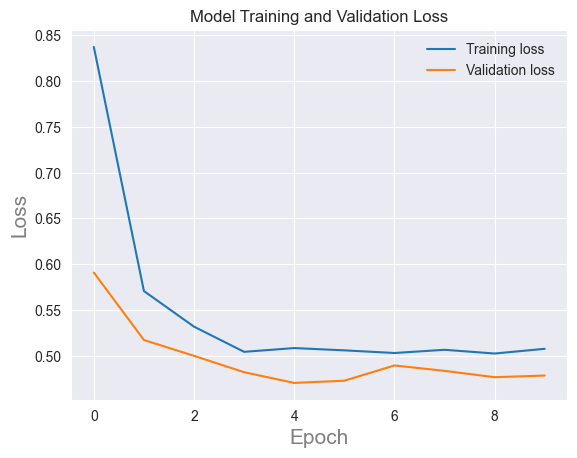

In [24]:
sns.set_style('darkgrid')
plt.plot(Train_loss, label='Training loss')
plt.plot(Valid_loss, label='Validation loss')
plt.legend(frameon=False)
plt.xlabel('Epoch', size=15, color='gray')
plt.ylabel('Loss', size=15, color='gray')
plt.title('Model Training and Validation Loss')
plt.show()

### Evaluate Model Accuracy

In [25]:
model.load_state_dict(torch.load('../model/model.pt'))
model.eval()
correct_preds, total_preds = 0, 0
all_preds, all_labels = [], []

C:\Users\ACER\AppData\Local\Temp\ipykernel_34332\3311052161.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('../model/model.pt'))


In [26]:
for images, labels in test_dataloader:
    images, labels = images.to(device), labels.to(device)
    with torch.no_grad():
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        correct_preds += (predicted == labels).sum().item()
        total_preds += labels.size(0)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

In [27]:
accuracy = (correct_preds / total_preds) * 100
print(f'Test Accuracy: {accuracy:.2f}%')

Test Accuracy: 87.17%


### Confusion Matrix

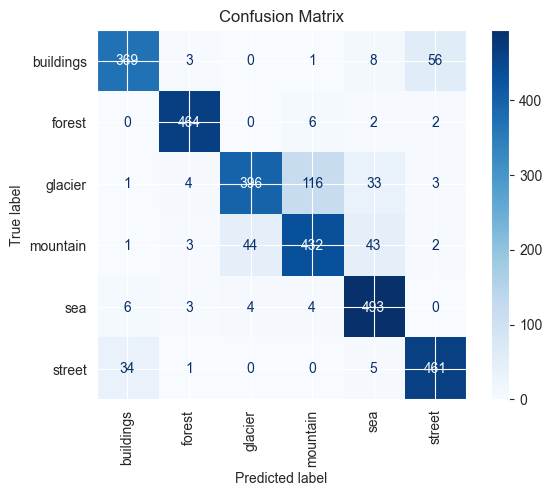

In [28]:
cm = confusion_matrix(all_labels, all_preds)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=train_data.classes)
cm_display.plot(cmap="Blues", xticks_rotation="vertical")
plt.title("Confusion Matrix")
plt.show()

### Classification Report

In [29]:
print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=train_data.classes))

Classification Report:
              precision    recall  f1-score   support

   buildings       0.90      0.84      0.87       437
      forest       0.97      0.98      0.97       474
     glacier       0.89      0.72      0.79       553
    mountain       0.77      0.82      0.80       525
         sea       0.84      0.97      0.90       510
      street       0.88      0.92      0.90       501

    accuracy                           0.87      3000
   macro avg       0.88      0.87      0.87      3000
weighted avg       0.87      0.87      0.87      3000

